In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]

print("🚀 Feature Engineering - Aviation Safety Research")
print("=" * 60)

# Cell 2: Load Enhanced Datasets
print("📥 Loading enhanced datasets...")
accidents = pd.read_csv('../data/processed/accidents_enhanced.csv')
safety = pd.read_csv('../data/processed/safety_enhanced.csv')

print(f"✅ Accidents data: {accidents.shape}")
print(f"✅ Safety data: {safety.shape}")

🚀 Feature Engineering - Aviation Safety Research
📥 Loading enhanced datasets...
✅ Accidents data: (84983, 42)
✅ Safety data: (56, 14)


In [2]:
# Cell 3: Initialize Feature Engineering Class
class AviationFeatureEngineer:
    def __init__(self):
        self.scalers = {}
        self.encoders = {}
        self.feature_selector = None
        
    def create_temporal_features(self, df):
        """Create advanced temporal features"""
        print("⏰ Creating temporal features...")
        
        if 'Event.Date' in df.columns:
            df['Event.Date'] = pd.to_datetime(df['Event.Date'])
            
            # Advanced temporal features
            df['DayOfYear'] = df['Event.Date'].dt.dayofyear
            df['WeekOfYear'] = df['Event.Date'].dt.isocalendar().week
            df['Quarter'] = df['Event.Date'].dt.quarter
            
            # Cyclical features for seasonality
            df['Year_Sin'] = np.sin(2 * np.pi * df['DayOfYear']/365)
            df['Year_Cos'] = np.cos(2 * np.pi * df['DayOfYear']/365)
            df['Month_Sin'] = np.sin(2 * np.pi * df['Month']/12)
            df['Month_Cos'] = np.cos(2 * np.pi * df['Month']/12)
            
            # Business features
            df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
            df['Is_Holiday_Season'] = df['Month'].isin([11, 12]).astype(int)
            df['Is_Summer'] = df['Month'].isin([6, 7, 8]).astype(int)
        
        return df
    
    def create_risk_composite_features(self, df):
        """Create composite risk scores"""
        print("🎯 Creating risk composite features...")
        
        # Weather risk mapping (higher = more risky)
        weather_risk_map = {
            'VMC': 1, 'Unknown': 2, 'UNK': 2,
            'IMC': 4, 'Rain': 3, 'Snow': 5, 
            'Fog': 3, 'Storm': 6, 'Thunderstorm': 6
        }
        df['Weather_Risk_Score'] = df['Weather.Condition'].map(
            lambda x: weather_risk_map.get(x, 2)
        ).fillna(2)
        
        # Flight phase risk mapping
        flight_phase_risk = {
            'Takeoff': 4, 'Landing': 4, 'Climb': 3, 
            'Descent': 3, 'Cruise': 2, 'Taxi': 1,
            'Approach': 4, 'Standing': 1
        }
        df['Flight_Phase_Risk'] = df['Broad.Phase.of.Flight'].map(
            lambda x: flight_phase_risk.get(x, 2)
        ).fillna(2)
        
        # Aircraft category risk
        aircraft_risk = {
            'Airplane': 2, 'Helicopter': 3, 'Glider': 4,
            'Balloon': 4, 'Unknown': 2, 'Amphibian': 3
        }
        df['Aircraft_Risk'] = df['Aircraft.Category'].map(
            lambda x: aircraft_risk.get(x, 2)
        ).fillna(2)
        
        # Injury severity risk
        injury_risk = {
            'Non-Fatal': 1, 'Minor': 2, 'Serious': 3,
            'Fatal': 5, 'Unknown': 2, 'Unavailable': 2
        }
        df['Injury_Risk_Score'] = df['Injury.Severity'].map(
            lambda x: injury_risk.get(x, 2)
        ).fillna(2)
        
        # Composite risk score
        df['Composite_Risk_Score'] = (
            df['Weather_Risk_Score'] * 0.25 +
            df['Flight_Phase_Risk'] * 0.35 +
            df['Aircraft_Risk'] * 0.20 +
            df['Injury_Risk_Score'] * 0.20
        )
        
        return df
    
    def create_operational_features(self, df):
        """Create operational risk features"""
        print("🏢 Creating operational features...")
        
        # Total people involved
        injury_cols = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 
                      'Total.Minor.Injuries', 'Total.Uninjured']
        
        for col in injury_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        if all(col in df.columns for col in injury_cols):
            df['Total_People_Involved'] = df[injury_cols].sum(axis=1)
            df['Fatality_Rate'] = df['Total.Fatal.Injuries'] / (df['Total_People_Involved'] + 1)  # Add 1 to avoid div by zero
            df['Fatality_Rate'] = df['Fatality_Rate'].replace([np.inf, -np.inf], 0).fillna(0)
        
        # Aircraft age proxy (if available)
        if 'Year' in df.columns:
            current_year = 2024
            df['Aircraft_Age_Proxy'] = current_year - df['Year']
            df['Aircraft_Age_Proxy'] = df['Aircraft_Age_Proxy'].fillna(df['Aircraft_Age_Proxy'].median())
        
        return df
    
    def encode_categorical_features(self, df, categorical_columns):
        """Encode categorical variables"""
        print("🔤 Encoding categorical features...")
        
        for col in categorical_columns:
            if col in df.columns:
                # Handle missing values
                df[col] = df[col].fillna('Unknown')
                
                # Create encoder
                self.encoders[col] = LabelEncoder()
                df[f'{col}_encoded'] = self.encoders[col].fit_transform(df[col])
        
        return df
    
    def create_interaction_features(self, df):
        """Create interaction features"""
        print("🔄 Creating interaction features...")
        
        # Risk score interactions
        df['Weather_Phase_Interaction'] = df['Weather_Risk_Score'] * df['Flight_Phase_Risk']
        df['Weather_Aircraft_Interaction'] = df['Weather_Risk_Score'] * df['Aircraft_Risk']
        
        # Temporal risk interactions
        if 'Month' in df.columns:
            df['Month_Risk_Interaction'] = df['Month'] * df['Composite_Risk_Score']
        
        # Safety score interactions (if available)
        if 'Safety_Score_Normalized' in df.columns:
            df['Safety_Weather_Interaction'] = df['Safety_Score_Normalized'] * df['Weather_Risk_Score']
            df['Safety_Phase_Interaction'] = df['Safety_Score_Normalized'] * df['Flight_Phase_Risk']
        
        return df
    
    def merge_safety_data(self, accidents_df, safety_df):
        """Merge accidents with safety data"""
        print("🔗 Merging with safety data...")
        
        # Extract airline name from operator
        accidents_df['Airline_Extracted'] = accidents_df['Air.Carrier'].str.extract(r'([A-Za-z\s]+)')[0]
        
        # Simple airline mapping for demonstration
        airline_mapping = {
            'DELTA': 'Delta', 'AMERICAN': 'American', 'UNITED': 'United',
            'SOUTHWEST': 'Southwest', 'LUFTHANSA': 'Lufthansa', 'EMIRATES': 'Emirates'
        }
        
        accidents_df['Airline_Matched'] = accidents_df['Airline_Extracted'].str.upper().map(airline_mapping)
        
        # Merge with safety data
        merged_df = accidents_df.merge(
            safety_df, 
            left_on='Airline_Matched', 
            right_on='airline', 
            how='left'
        )
        
        # Fill missing safety data with averages
        safety_columns = ['Safety_Score_Normalized', 'Incident_Rate', 'Total_Incidents']
        for col in safety_columns:
            if col in merged_df.columns:
                merged_df[col] = merged_df[col].fillna(merged_df[col].mean())
        
        return merged_df

In [3]:
# Cell 4: Initialize Feature Engineer
feature_engineer = AviationFeatureEngineer()

# Cell 5: Apply Feature Engineering
print("🚀 Starting comprehensive feature engineering...")

# Temporal features
accidents_enhanced = feature_engineer.create_temporal_features(accidents)

# Risk composite features
accidents_enhanced = feature_engineer.create_risk_composite_features(accidents_enhanced)

# Operational features
accidents_enhanced = feature_engineer.create_operational_features(accidents_enhanced)

# Encode categorical features
categorical_columns = [
    'Injury.Severity', 'Aircraft.Damage', 'Aircraft.Category',
    'Engine.Type', 'Weather.Condition', 'Broad.Phase.of.Flight'
]
accidents_enhanced = feature_engineer.encode_categorical_features(
    accidents_enhanced, categorical_columns
)

# Interaction features
accidents_enhanced = feature_engineer.create_interaction_features(accidents_enhanced)

# Merge with safety data
final_dataset = feature_engineer.merge_safety_data(accidents_enhanced, safety)

print(f"✅ Feature engineering completed! Final dataset: {final_dataset.shape}")

# Cell 6: Feature Selection and Analysis
print("\n🔍 FEATURE ANALYSIS AND SELECTION")
print("=" * 50)

# Define feature columns (excluding target and ID columns)
feature_columns = [
    # Temporal features
    'Year', 'Month', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter',
    'Year_Sin', 'Year_Cos', 'Month_Sin', 'Month_Cos',
    'Is_Weekend', 'Is_Holiday_Season', 'Is_Summer',
    
    # Risk scores
    'Weather_Risk_Score', 'Flight_Phase_Risk', 'Aircraft_Risk',
    'Injury_Risk_Score', 'Composite_Risk_Score',
    
    # Operational features
    'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries',
    'Total_People_Involved', 'Fatality_Rate', 'Aircraft_Age_Proxy',
    
    # Encoded categorical features
    'Injury.Severity_encoded', 'Aircraft.Damage_encoded', 'Aircraft.Category_encoded',
    'Engine.Type_encoded', 'Weather.Condition_encoded', 'Broad.Phase.of.Flight_encoded',
    
    # Interaction features
    'Weather_Phase_Interaction', 'Weather_Aircraft_Interaction',
    'Month_Risk_Interaction',
    
    # Safety metrics
    'Safety_Score_Normalized', 'Incident_Rate', 'Total_Incidents',
    'Safety_Weather_Interaction', 'Safety_Phase_Interaction'
]

# Only use columns that exist in the dataset
available_features = [col for col in feature_columns if col in final_dataset.columns]

print(f"Available features for modeling: {len(available_features)}")
print("Feature list:")
for i, feature in enumerate(available_features, 1):
    print(f"  {i:2d}. {feature}")


🚀 Starting comprehensive feature engineering...
⏰ Creating temporal features...
🎯 Creating risk composite features...
🏢 Creating operational features...
🔤 Encoding categorical features...
🔄 Creating interaction features...
🔗 Merging with safety data...
✅ Feature engineering completed! Final dataset: (84983, 79)

🔍 FEATURE ANALYSIS AND SELECTION
Available features for modeling: 36
Feature list:
   1. Year
   2. Month
   3. DayOfWeek
   4. DayOfYear
   5. WeekOfYear
   6. Quarter
   7. Year_Sin
   8. Year_Cos
   9. Month_Sin
  10. Month_Cos
  11. Is_Weekend
  12. Is_Holiday_Season
  13. Is_Summer
  14. Weather_Risk_Score
  15. Flight_Phase_Risk
  16. Aircraft_Risk
  17. Injury_Risk_Score
  18. Composite_Risk_Score
  19. Total.Fatal.Injuries
  20. Total.Serious.Injuries
  21. Total.Minor.Injuries
  22. Total_People_Involved
  23. Fatality_Rate
  24. Aircraft_Age_Proxy
  25. Injury.Severity_encoded
  26. Aircraft.Damage_encoded
  27. Aircraft.Category_encoded
  28. Engine.Type_encoded
  29


🎯 PREPARING FEATURES AND TARGET
🔧 Handling missing values...
Missing values before cleaning: 254949
Missing values after cleaning: 0
Infinite values after cleaning: 0

Feature matrix: (84983, 36)
Target distribution:
Severe_Accident
0    61995
1    22988
Name: count, dtype: int64
Severe accident rate: 27.050%

📊 FEATURE IMPORTANCE ANALYSIS
Top 20 Most Important Features:


,feature,importance
25,Aircraft.Damage_encoded,0.367470
22,Fatality_Rate,0.214453
18,Total.Fatal.Injuries,0.180142
24,Injury.Severity_encoded,0.076671
16,Injury_Risk_Score,0.060521
17,Composite_Risk_Score,0.042314
19,Total.Serious.Injuries,0.007056
31,Weather_Aircraft_Interaction,0.004640
32,Month_Risk_Interaction,0.004266
21,Total_People_Involved,0.003901


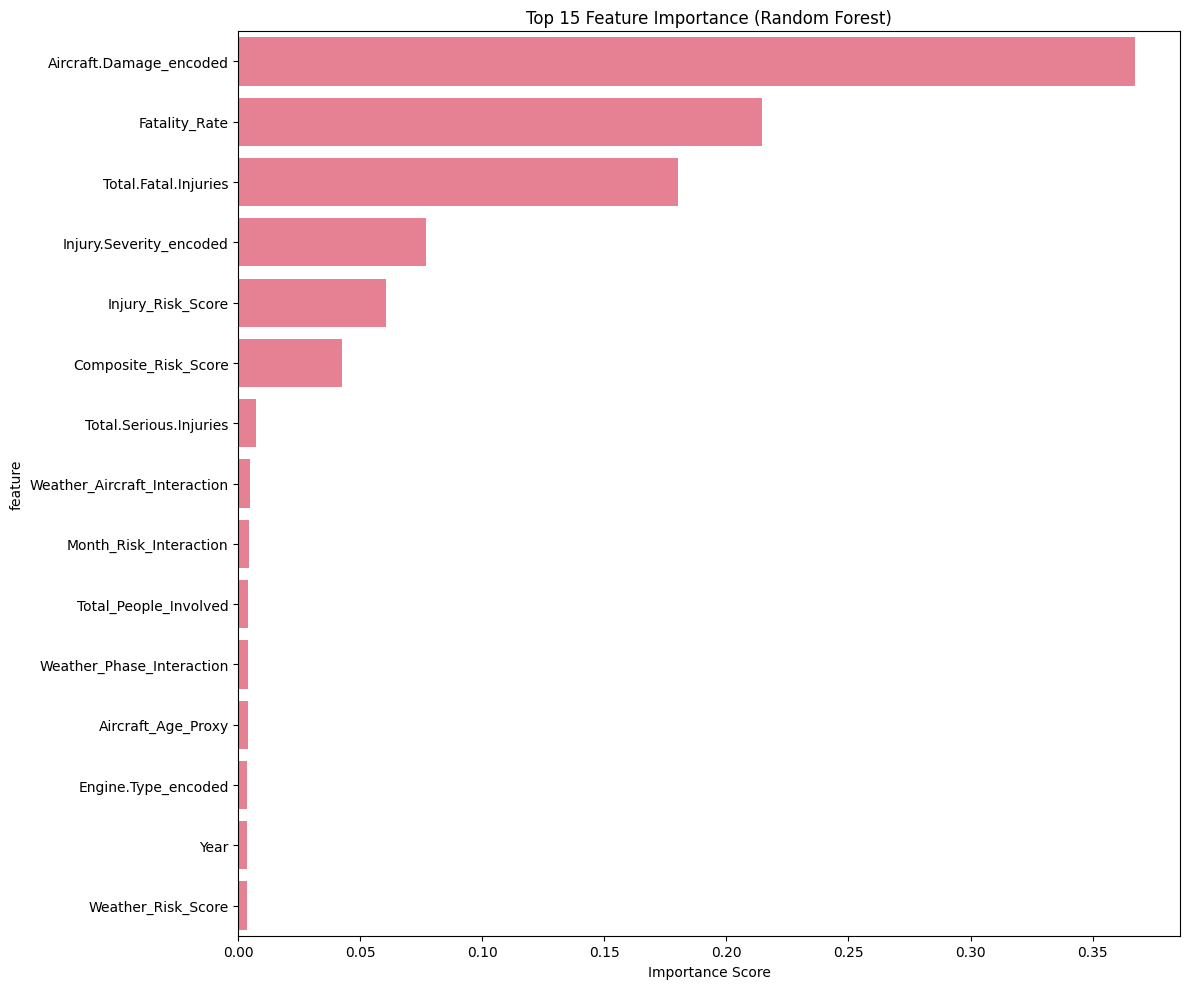

In [4]:
# Cell 7: Prepare Features and Target
print("\n🎯 PREPARING FEATURES AND TARGET")
print("=" * 50)

X = final_dataset[available_features].copy()
y = final_dataset['Severe_Accident']

# Handle missing values - COMPREHENSIVE APPROACH
print("🔧 Handling missing values...")
print(f"Missing values before cleaning: {X.isnull().sum().sum()}")

# Fill numeric columns with median
numeric_cols = X.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Fill any remaining NaNs with 0
X = X.fillna(0)

# Replace inf values in numeric columns only
for col in numeric_cols:
    X[col] = X[col].replace([np.inf, -np.inf], 0)

print(f"Missing values after cleaning: {X.isnull().sum().sum()}")

# Check for infinite values only in numeric columns
inf_count = sum(np.isinf(X[col].values).sum() for col in numeric_cols)
print(f"Infinite values after cleaning: {inf_count}")

print(f"\nFeature matrix: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Severe accident rate: {y.mean():.3%}")

# Cell 8: Feature Importance Analysis
print("\n📊 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data for feature importance analysis
X_temp, _, y_temp, _ = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
display(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 10))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('../papers/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()



📈 FEATURE CORRELATION ANALYSIS
Top 15 Features by Correlation with Target:


,Feature,Correlation,Abs_Correlation
25,Aircraft.Damage_encoded,-0.814121,0.814121
22,Fatality_Rate,0.784202,0.784202
24,Injury.Severity_encoded,-0.765806,0.765806
16,Injury_Risk_Score,0.705299,0.705299
17,Composite_Risk_Score,0.456019,0.456019
28,Weather.Condition_encoded,-0.258104,0.258104
30,Weather_Phase_Interaction,0.253215,0.253215
13,Weather_Risk_Score,0.253215,0.253215
31,Weather_Aircraft_Interaction,0.249864,0.249864
18,Total.Fatal.Injuries,0.181227,0.181227


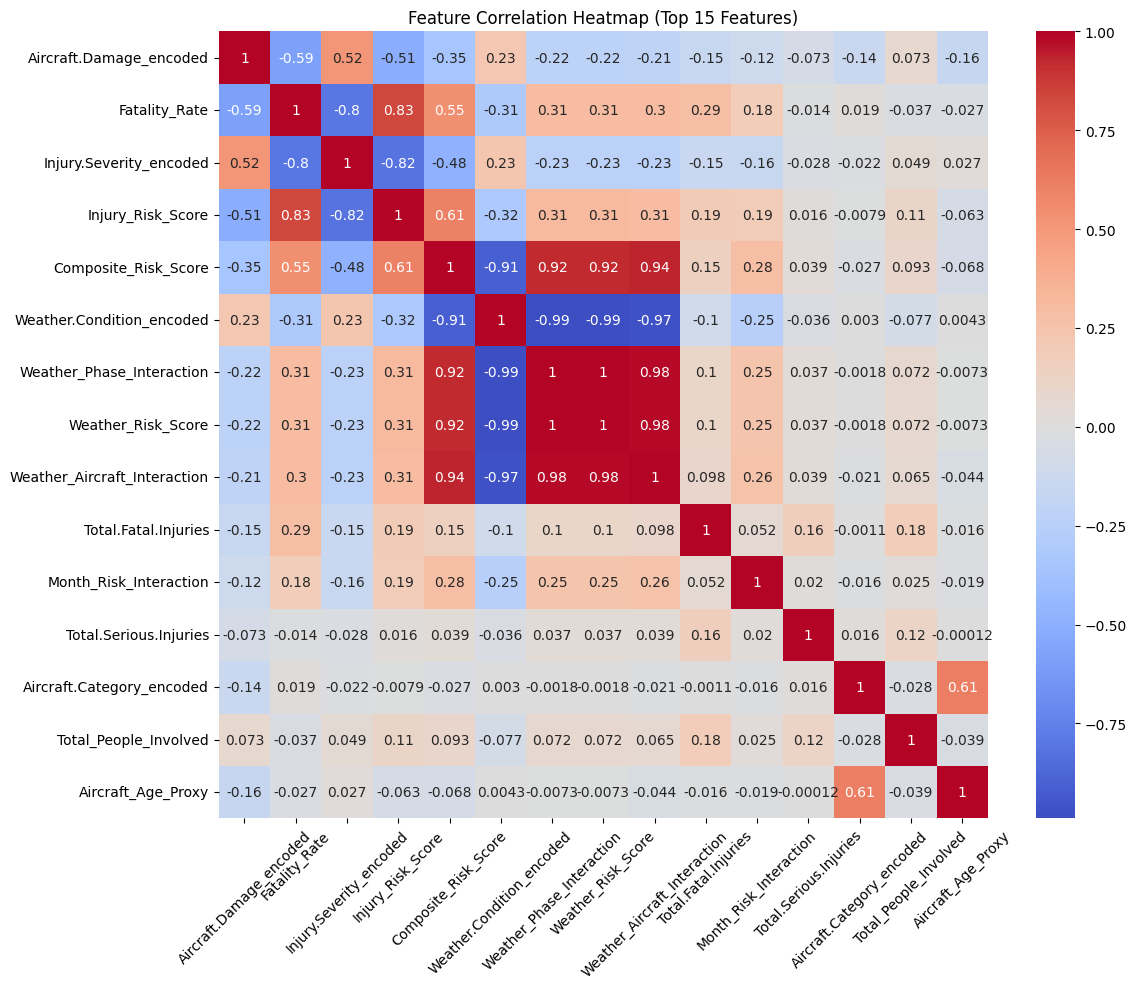

In [5]:
# Cell 9: Correlation Analysis
print("\n📈 FEATURE CORRELATION ANALYSIS")
print("=" * 50)

# Calculate correlation with target
correlation_with_target = []
for feature in available_features:
    corr = np.corrcoef(X[feature], y)[0, 1]
    correlation_with_target.append((feature, corr))

correlation_df = pd.DataFrame(correlation_with_target, columns=['Feature', 'Correlation'])
correlation_df['Abs_Correlation'] = correlation_df['Correlation'].abs()
correlation_df = correlation_df.sort_values('Abs_Correlation', ascending=False)

print("Top 15 Features by Correlation with Target:")
display(correlation_df.head(15))

# Plot correlation heatmap for top features
top_features = correlation_df.head(15)['Feature'].tolist()
correlation_matrix = X[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            xticklabels=top_features, yticklabels=top_features)
plt.title('Feature Correlation Heatmap (Top 15 Features)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../papers/figures/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Cell 10: Feature Scaling
print("\n⚖️ FEATURE SCALING")
print("=" * 50)

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Scale features
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=available_features)

# Verify no NaNs or inf after scaling
print(f"NaNs in scaled features: {X_scaled.isnull().sum().sum()}")

# Check inf only in numeric columns
scaled_numeric_cols = X_scaled.select_dtypes(include=[np.number]).columns
inf_count_scaled = sum(np.isinf(X_scaled[col].values).sum() for col in scaled_numeric_cols)
print(f"Inf values in scaled features: {inf_count_scaled}")

# Final safety check - replace any NaNs/inf that might have appeared
X_scaled = X_scaled.fillna(0)
for col in scaled_numeric_cols:
    X_scaled[col] = X_scaled[col].replace([np.inf, -np.inf], 0)

print("✅ Features scaled successfully!")
print(f"Scaled feature matrix: {X_scaled.shape}")

# Cell 11: Final Feature Selection
print("\n🎯 FINAL FEATURE SELECTION")
print("=" * 50)

from sklearn.feature_selection import SelectKBest, f_classif

# Final verification before feature selection
print("🔍 Pre-selection data quality check:")
print(f"  • X_scaled shape: {X_scaled.shape}")
print(f"  • y shape: {y.shape}")
print(f"  • NaN in X_scaled: {X_scaled.isnull().sum().sum()}")

# Check inf only in numeric columns
scaled_inf_count = sum(np.isinf(X_scaled[col].values).sum() for col in X_scaled.select_dtypes(include=[np.number]).columns)
print(f"  • Inf in X_scaled: {scaled_inf_count}")
print(f"  • NaN in y: {y.isnull().sum()}")

# Select top k features based on ANOVA F-test
k = min(30, len(available_features))  # Select top 30 features
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = [available_features[i] for i in selector.get_support(indices=True)]

print(f"\n✅ Selected {len(selected_features)} features for modeling:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i:2d}. {feature}")

# Cell 12: Save Processed Features
print("\n💾 SAVING PROCESSED FEATURES")
print("=" * 50)

# Create final dataset with selected features
final_features_df = X_scaled[selected_features].copy()
final_features_df['Severe_Accident'] = y.values

# Save to file
final_features_df.to_csv('../data/processed/final_features.csv', index=False)

# Save feature names
import joblib
joblib.dump(selected_features, '../models/selected_features.pkl')
joblib.dump(scaler, '../models/feature_scaler.pkl')

print("✅ Final features saved successfully!")
print(f"Final dataset shape: {final_features_df.shape}")
print(f"Selected features: {len(selected_features)}")
print(f"Target positive rate: {y.mean():.3%}")

# Cell 13: Feature Engineering Summary
print("\n🎉 FEATURE ENGINEERING SUMMARY")
print("=" * 50)

print("📊 FEATURE CATEGORIES CREATED:")
feature_categories = {
    'Temporal Features': ['Year', 'Month', 'DayOfWeek', 'Seasonal_Cycles'],
    'Risk Scores': ['Weather_Risk', 'Flight_Phase_Risk', 'Composite_Risk'],
    'Operational Metrics': ['Injury_Counts', 'People_Involved', 'Fatality_Rate'],
    'Safety Integration': ['Airline_Safety_Score', 'Incident_Rate'],
    'Interaction Terms': ['Weather_Phase_Interaction', 'Safety_Risk_Interactions']
}

for category, features in feature_categories.items():
    print(f"  • {category}: {len(features)} features")

print(f"\n🎯 FINAL FEATURE SET: {len(selected_features)} features")
print(f"📈 TARGET DISTRIBUTION:")
print(f"   - Severe Accidents: {y.sum()} ({y.mean():.2%})")
print(f"   - Non-Severe Accidents: {len(y) - y.sum()} ({1-y.mean():.2%})")

print("\n🚀 NEXT STEPS:")
print("   • Proceed to Model Training (03_model_experiments.ipynb)")
print("   • Use final_features.csv for model development")
print("   • Selected features and scaler are saved in models/ directory")

print("\n✅ FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")



⚖️ FEATURE SCALING
NaNs in scaled features: 0
Inf values in scaled features: 0
✅ Features scaled successfully!
Scaled feature matrix: (84983, 36)

🎯 FINAL FEATURE SELECTION
🔍 Pre-selection data quality check:
  • X_scaled shape: (84983, 36)
  • y shape: (84983,)
  • NaN in X_scaled: 0
  • Inf in X_scaled: 0
  • NaN in y: 0

✅ Selected 30 features for modeling:
   1. Year
   2. Month
   3. DayOfYear
   4. WeekOfYear
   5. Quarter
   6. Year_Sin
   7. Year_Cos
   8. Month_Sin
   9. Month_Cos
  10. Is_Holiday_Season
  11. Is_Summer
  12. Weather_Risk_Score
  13. Aircraft_Risk
  14. Injury_Risk_Score
  15. Composite_Risk_Score
  16. Total.Fatal.Injuries
  17. Total.Serious.Injuries
  18. Total.Minor.Injuries
  19. Total_People_Involved
  20. Fatality_Rate
  21. Aircraft_Age_Proxy
  22. Injury.Severity_encoded
  23. Aircraft.Damage_encoded
  24. Aircraft.Category_encoded
  25. Engine.Type_encoded
  26. Weather.Condition_encoded
  27. Broad.Phase.of.Flight_encoded
  28. Weather_Phase_Intera